In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.chdir('02514-Deep-Learning-In-Computer-Vision/')
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from dataloader import Lesion_Data, DRIVE_data


import matplotlib.pyplot as plt
from IPython.display import clear_output

print("Running on ", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Running on  cuda


In [5]:
torch.cuda.empty_cache()

# Load the data from the first dataset


In [6]:
size = 128
batch_size = 2

dataset = Lesion_Data(train_transform_size=size, test_transform_size=size)
trainset, testset, validationset = dataset.get_datasets()

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=3)

In [7]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))
print('Loaded %d validation images' % len(validationset))

Loaded 128 training images
Loaded 40 test images
Loaded 32 validation images


IndexError: index 2 is out of bounds for dimension 0 with size 2

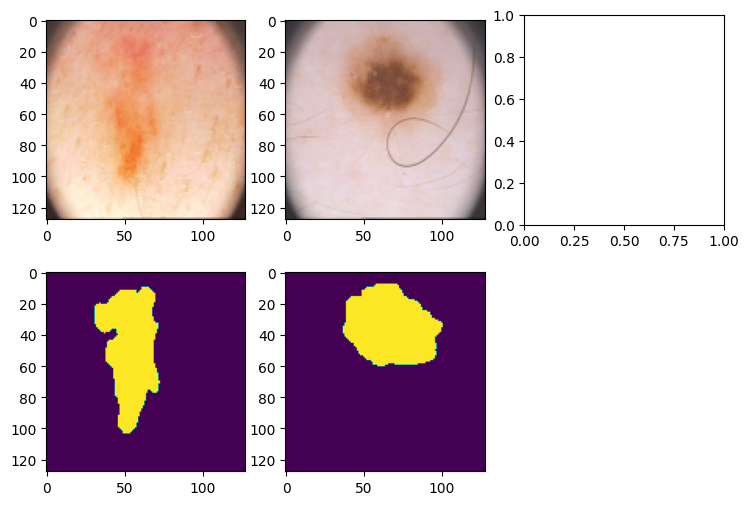

In [8]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
! nvidia-smi

## Set cuda device based on the output 

In [9]:
torch.cuda.device('cuda:0')

## Create a simple CNN

In [10]:
class PH2SegmentationCNN(nn.Module):
    def __init__(self, num_classes):
        super(PH2SegmentationCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.final_conv = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)

        x = self.final_conv(x)
        return x

In [11]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            # loss = loss_fn(Y_batch, torch.argmax(Y_pred, dim = 1))  # forward-pass
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [12]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [13]:
# Leasion | Not leasion data
model =PH2SegmentationCNN(num_classes=2).to(device)
summary(model, (3, 128, 128))

NameError: name 'device' is not defined

In [14]:
train(model, optim.Adam(model.parameters()), nn.CrossEntropyLoss(), 20, train_loader, test_loader)

NameError: name 'model' is not defined